## Начало

Обучим модель полиномиальной регрессии третьей степени. Будем использовать данные о жилье в Бостоне и возьмём следующие четыре признака: LSTAT, CRIM, PTRATIO и RM.

Для оценки качества модели будем использовать кросс-валидацию и сравнивать среднее значение метрики на тренировочных и валидационных фолдах. Кросс-валидацию организуем с помощью функции cross_validate из модуля model_selection:

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

В качестве метрики используем среднюю абсолютную процентную ошибку — MAPE.

In [3]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'PRICE']
boston_data = pd.read_csv('data/housing.csv', header=None, delimiter=r"\s+", names=column_names)

In [4]:
# выделяем интересующие нас факторы
X = boston_data[['LSTAT', 'PTRATIO', 'RM','CRIM']]
y = boston_data[['PRICE']]
 
# добавляем полиномиальные признаки
poly = PolynomialFeatures(degree=3, include_bias=False)
X = poly.fit_transform(X)
 
# создаём модель линейной регрессии
lr = LinearRegression()
 
# оцениваем качество модели на кросс-валидации, метрика — MAPE
cv_results = cross_validate(lr, X, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_score'].mean() * 100))	
 
## MAPE на тренировочных фолдах: 12.64 %
## MAPE на валидационных фолдах: 24.16 %

MAPE на тренировочных фолдах: 12.64 %
MAPE на валидационных фолдах: 24.16 %


Что мы видим? Даже при, казалось бы, небольшой, третьей степени полинома мы получили переобучение: на тренировочной выборке ***MAPE = 12.64%***, а вот на тестовой — ***MAPE = 24.16%***. Показатели качества отличаются практически в два раза, что говорит о высоком разбросе модели. Ещё более удручающий результат мы получим, если воспользуемся полиномом большей степени (при желании вы можете проверить это самостоятельно).

Как с этим справиться, мы тоже уже знаем.

- Можно попробовать понизить сложность модели (снизить степень полинома). Но до какой степени? Можно постепенно перебирать степень полинома до тех пор, пока не получим адекватные результаты, но, согласитесь, процедура не очень приятная.
- Можно воспользоваться методами регуляризации.

О втором способе как раз и поговорим подробнее с математической точки зрения.

Для начала вспомним, что такое **регуляризация.**

> **Регуляризация** — это способ уменьшения переобучения моделей машинного обучения путём намеренного увеличения смещения модели для уменьшения её разброса.

Регуляризация для линейной регрессии преследует сразу несколько целей. Однако далее мы увидим, что все эти цели на самом деле взаимосвязаны:

- предотвратить переобучение модели;
- включить в функцию потерь штраф за переобучение;
- обеспечить существование обратной матрицы 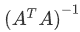;
- не допустить огромных коэффициентов модели.

> Мы знаем, что большие значения весов — прямое свидетельство переобучения модели линейной регрессии и её нестабильности. Идея регуляризации состоит в наложении ограничения на вектор весов (часто говорят — наложение штрафа за высокие веса). В качестве штрафа принято использовать **норму вектора весов.**

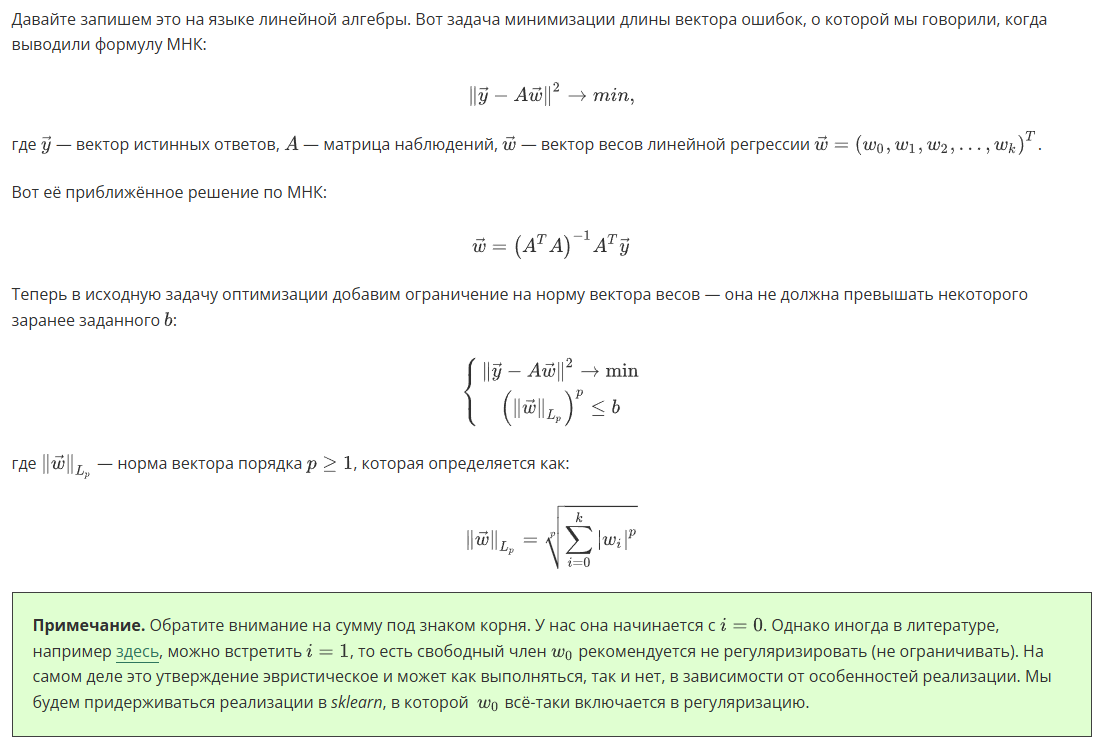
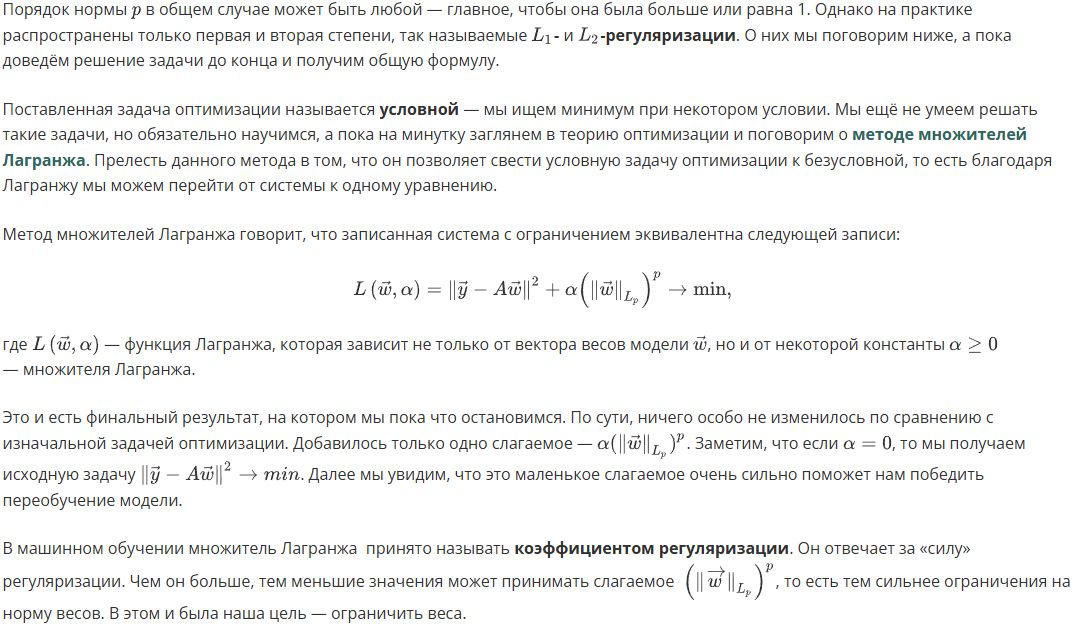

## L2-РЕГУЛЯРИЗАЦИЯ - теория

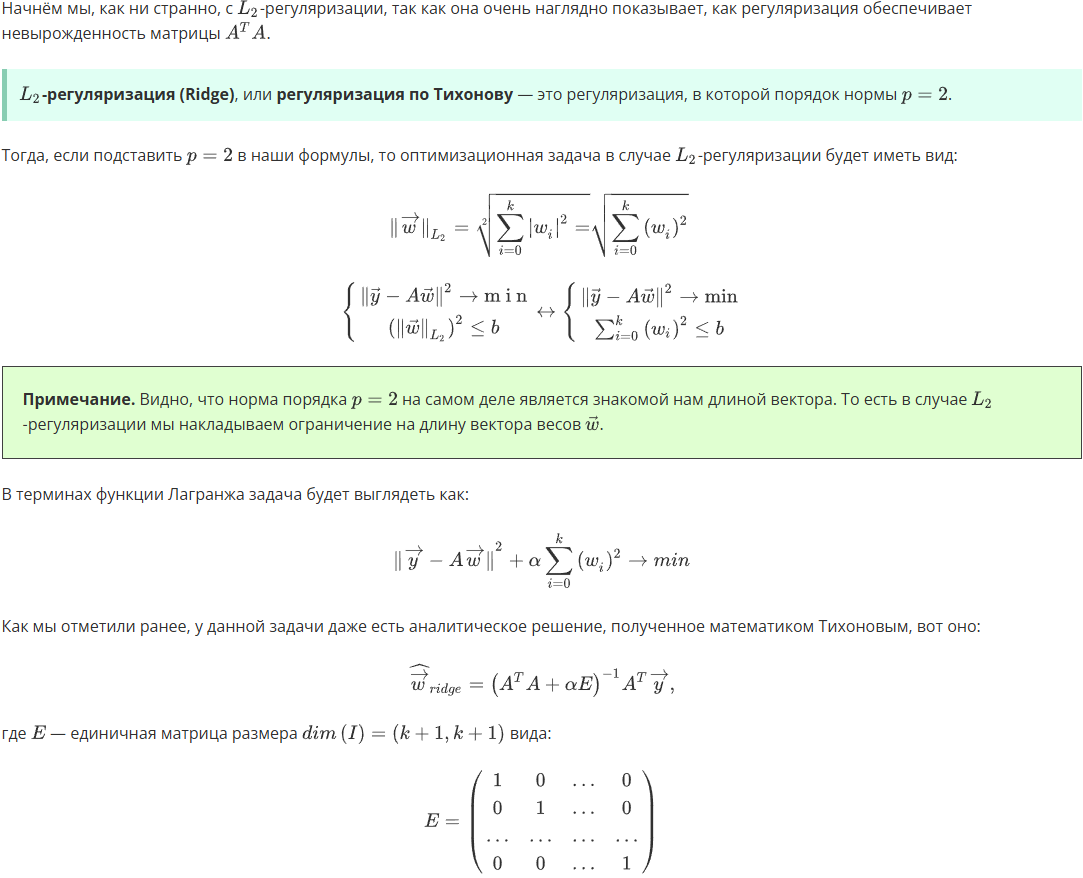
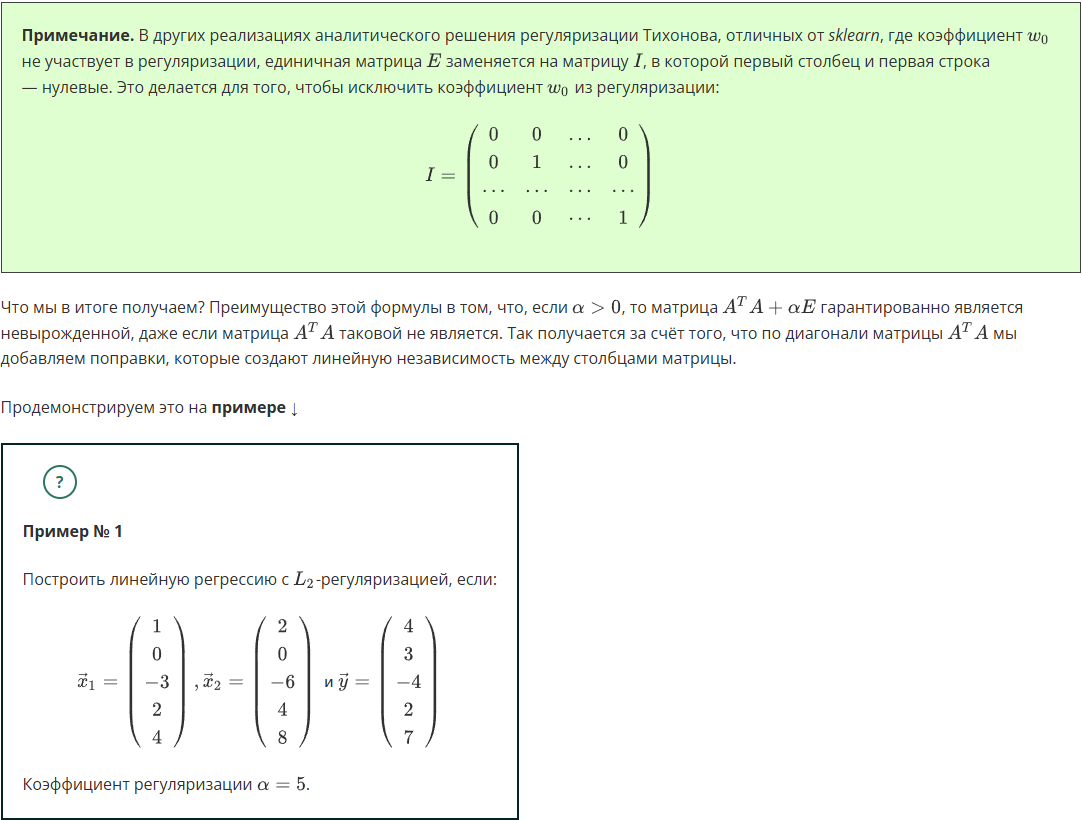
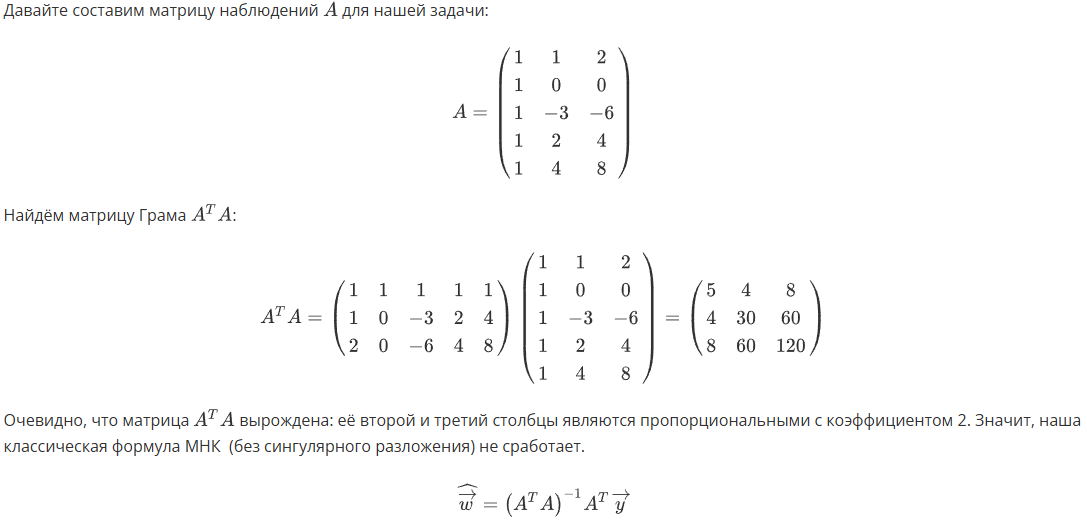

## L2-РЕГУЛЯРИЗАЦИЯ - проверка на python

In [4]:
# матрица наблюдений (включая столбец единиц)
A = np.array([
    [1, 1, 1, 1, 1],
    [1, 0, -3, 2, 4],
    [2, 0, -6, 4, 8]
]).T
# вектор целевого признака
y = np.array([4, 3, -4, 2, 7])
# получаем оценку коэффициентов регрессии по МНК
w_hat = np.linalg.inv(A.T@A)@A.T@y
print(w_hat) 
## LinAlgError: Singular matrix

LinAlgError: Singular matrix

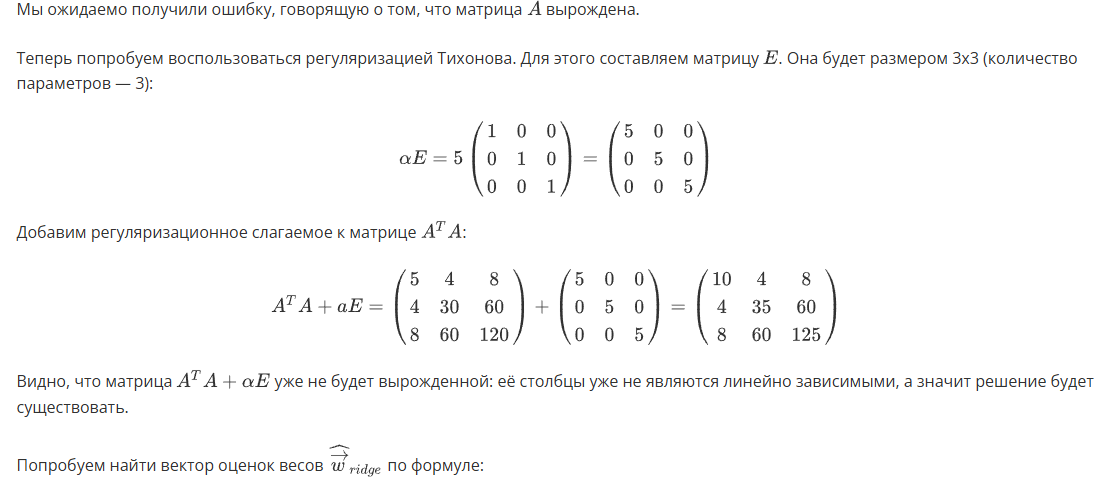

In [5]:
# матрица наблюдений (включая столбец единиц)
A = np.array([
    [1, 1, 1, 1, 1],
    [1, 0, -3, 2, 4],
    [2, 0, -6, 4, 8]
]).T
# вектор целевого признака
y = np.array([4, 3, -4, 2, 7])
# единичная матрица
E = np.eye(3)
# коэффициент регуляризации 
alpha = 5
# получаем оценку коэффициентов регрессии по МНК с регуляризацией Тихонова
w_hat_ridge = np.linalg.inv(A.T@A+alpha*E)@A.T@y
print(w_hat_ridge) 
## [0.6122449  0.29387755 0.5877551 ]

[0.6122449  0.29387755 0.5877551 ]


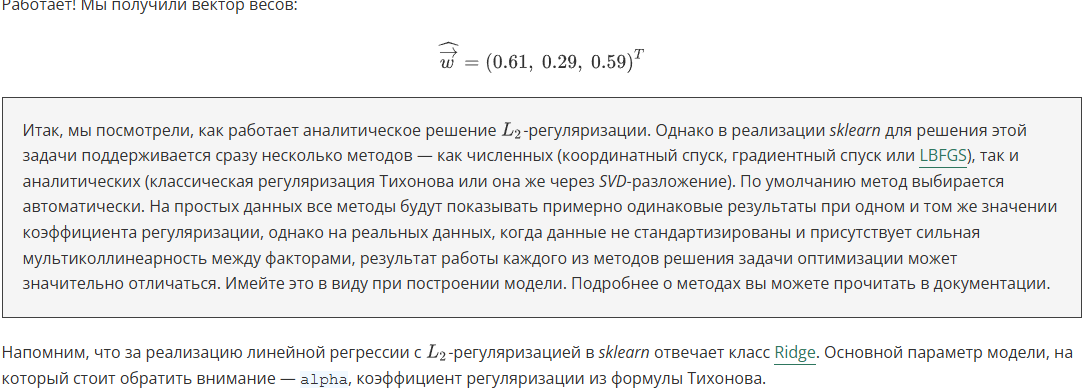

In [6]:
from sklearn.linear_model import Ridge

Давайте обучим модель для решения нашей последней задачи, а затем проверим коэффициенты регрессии. Так как мы заранее заложили в матрицу **A** столбец из единиц, то, чтобы получить корректное решение, параметр fit_intercept следует установить в значение False.

In [7]:
# матрица наблюдений (включая столбец единиц)
A = np.array([
    [1, 1, 1, 1, 1],
    [1, 0, -3, 2, 4],
    [2, 0, -6, 4, 8]
]).T
# вектор целевого признака
y = np.array([4, 3, -4, 2, 7])
# получаем оценку коэффициентов регрессии по МНК с регуляризацией Тихонова
ridge = Ridge(alpha=5, fit_intercept=False)
ridge.fit(A, y)
print(ridge.coef_) 
## [0.6122449  0.29387755 0.5877551 ]

[0.6122449  0.29387755 0.5877551 ]


Наконец, посмотрим, как регуляризация поможет побороть переобучение модели полиномиальной регрессии на наборе данных о домах в Бостоне. Используем те же самые признаки: LSTAT, CRIM, PTRATIO и RM. 

> Сразу отметим, что для успешной сходимости численных методов оптимизации, которые используются для решения задачи условной оптимизации, необходима стандартизация (нормализация) исходных данных, которая не требовалась для аналитического МНК в классической линейной регрессии (LinearRegression).

> **Примечание.** Здесь под **стандартизацией** мы понимаем именно приведение распределения признака к нулевому среднему и единичному стандартному отклонению (StandardScaler), а не стандартизацию векторов, о которой мы говорили в этом модуле. Последнюю также можно использовать в качестве способа масштабирования данных, однако её реализации нет в sklearn.

In [8]:
from sklearn.preprocessing import StandardScaler

Воспользуемся моделью полиномиальной регрессии третьей степени с регуляризацией Тихонова (коэффициент регуляризации возьмём равным 20) и проверим её качество на кросс-валидации по метрике MAPE.

In [9]:
# выделяем интересующие нас факторы
X = boston_data[['LSTAT', 'PTRATIO', 'RM','CRIM']]
y = boston_data[['PRICE']]
# инициализируем стандартизатор StandardScaler
scaler = StandardScaler()
# подгоняем параметры стандартизатора (вычисляем среднее и СКО)
X = scaler.fit_transform(X)
# добавляем полиномиальные признаки
poly = PolynomialFeatures(degree=3, include_bias=False)
X = poly.fit_transform(X)
# создаём модель линейной регрессии c L2-регуляризацией
ridge = Ridge(alpha=20, solver='svd')
# оцениваем качество модели на кросс-валидации
cv_results = cross_validate(ridge, X, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_score'].mean() * 100))
## MAPE на тренировочных фолдах: 12.54 %
## MAPE на валидационных фолдах: 17.02 %

MAPE на тренировочных фолдах: 12.54 %
MAPE на валидационных фолдах: 17.02 %


Нам удалось уменьшить ошибку (MAPE) на валидационных фолдах кросс-валидации с 24.16% до 17.02% и сократить разницу в метриках, тем самым уменьшив разброс ответов модели.


### Задание 7.4

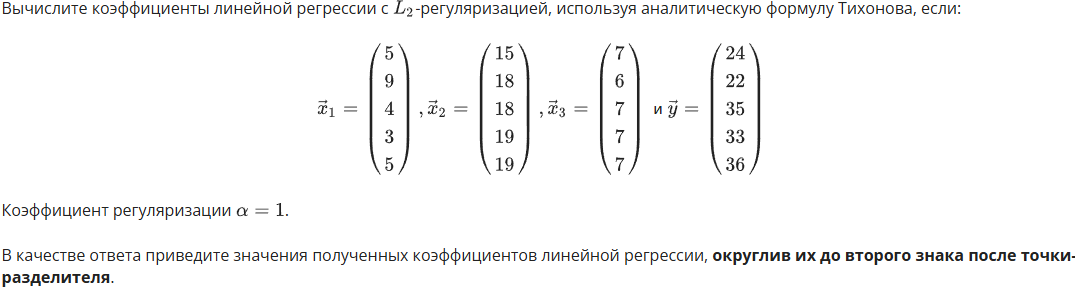

In [14]:
x1 = np.array([5,9,4,3,5])
x2 = np.array([15,18,18,19,19])
x3 = np.array([7,6,7,7,7])
y = np.array([24,22,35,33,36])

In [19]:
np.ones(5)

array([1., 1., 1., 1., 1.])

In [33]:
A = np.column_stack([np.ones(5), x1, x2, x3])
A

array([[ 1.,  5., 15.,  7.],
       [ 1.,  9., 18.,  6.],
       [ 1.,  4., 18.,  7.],
       [ 1.,  3., 19.,  7.],
       [ 1.,  5., 19.,  7.]])

In [34]:
# единичная матрица
E = np.eye(4)
# коэффициент регуляризации 
alpha = 1
# получаем оценку коэффициентов регрессии по МНК с регуляризацией Тихонова
w_hat_ridge = np.linalg.inv(A.T@A+alpha*E)@A.T@y
print(np.round(w_hat_ridge, 2)) 

[-0.09 -1.71  1.91  0.73]


## L1-РЕГУЛЯРИЗАЦИЯ - теория

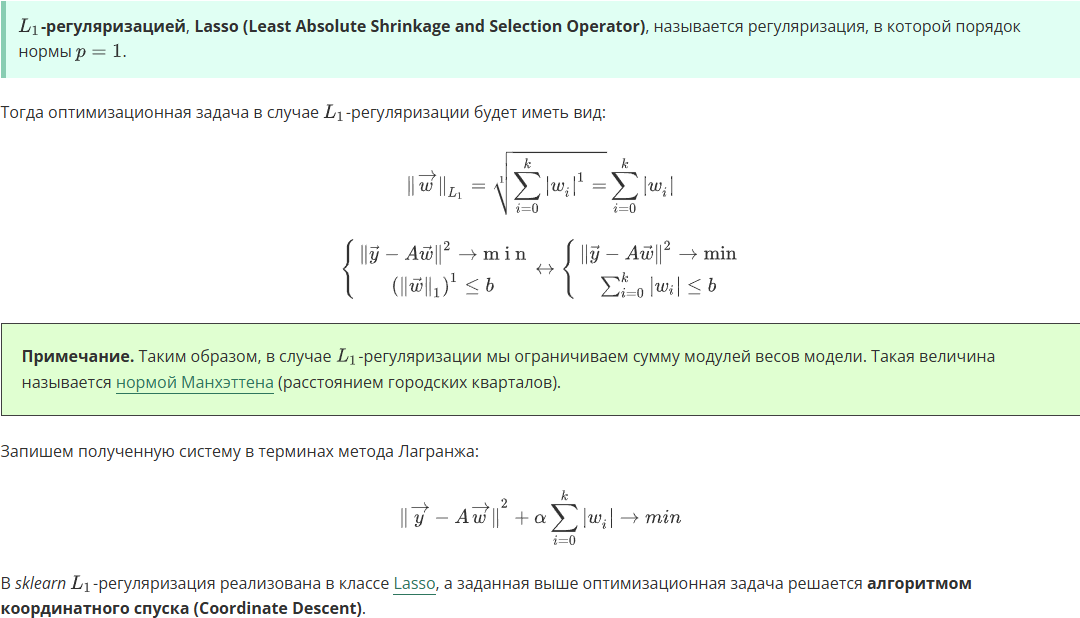

## L1-РЕГУЛЯРИЗАЦИЯ - проверка python

In [35]:
from sklearn.linear_model import Lasso

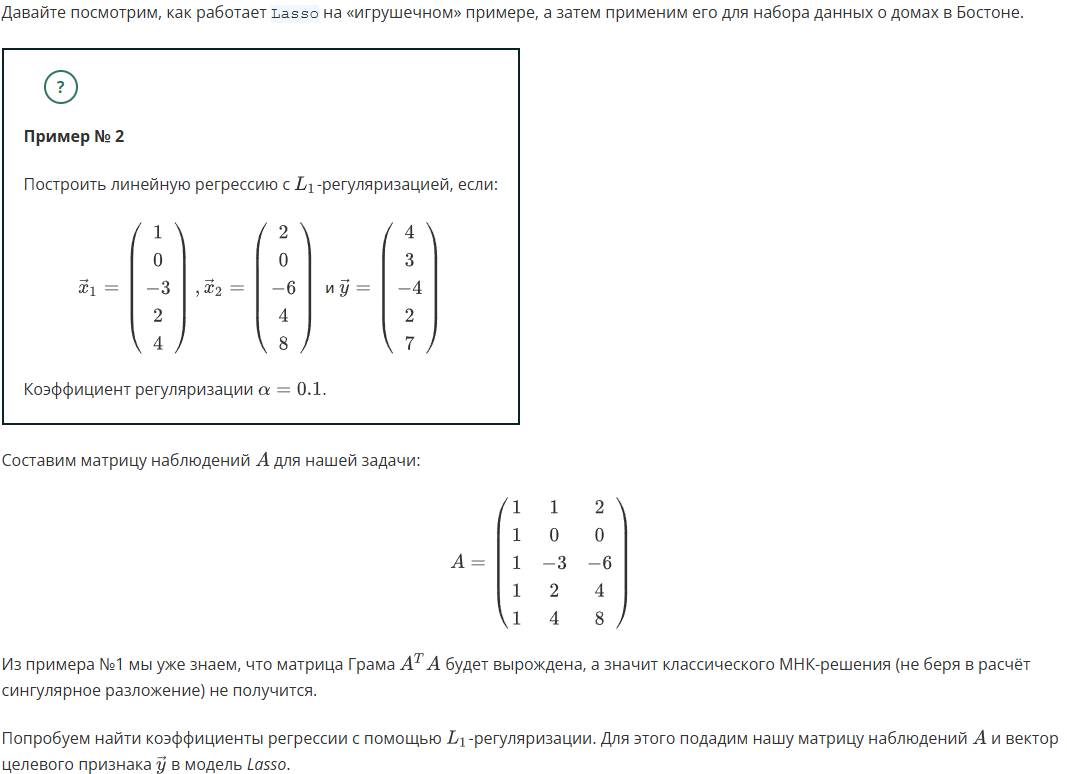

In [36]:
# матрица наблюдений (включая столбец единиц)
A = np.array([
    [1, 1, 1, 1, 1],
    [1, 0, -3, 2, 4],
    [2, 0, -6, 4, 8]
]).T
# вектор целевого признака
y = np.array([4, 3, -4, 2, 7])
# получаем оценку коэффициентов регрессии с помощью L1-регуляризации
lasso = Lasso(alpha=0.1, fit_intercept=False)
lasso.fit(A, y)
print(lasso.coef_)
## [1.14925373 0.         0.71921642]

[1.14925373 0.         0.71921642]


Вот наша оценка вектора весов

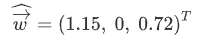

> Сразу обращаем внимание, что, в отличие от регуляризации Тихонова, L1-регуляризация «занулила» коэффициент, стоящий при факторе x1. Это произошло не случайно, так как это особенность данного метода. Как говорится, «не баг, а фича», причём очень важная. Коэффициенты, стоящие при коллинеарных или высококоррелированных факторах, зануляются. Также чем выше коэффициент регуляризации, тем больше вероятность того, что коррелированные или малозначащие факторы будут исключены из модели. Чуть позже мы рассмотрим геометрическую интерпретацию и поймём, почему так происходит.

А пока давайте применим L1-регуляризацию к нашей полиномиальной модели третьей степени, прогнозирующей типичную цену на дома в районах Бостона.

Так как метод координатного спуска, который применяется для поиска коэффициентов, является численным, то необходима стандартизация исходных данных, чтобы обеспечить ему сходимость. Возьмём в качестве коэффициента регуляризации a = 0.1 и проверим качество полученной модели с помощью кросс-валидации по метрике MAPE:

In [41]:
# выделяем интересующие нас факторы
X = boston_data[['LSTAT', 'PTRATIO', 'RM','CRIM']]
y = boston_data[['PRICE']]

# инициализируем стандартизатор StandardScaler
scaler = StandardScaler()
# подгоняем параметры стандартизатора (вычисляем среднее и СКО)
X = scaler.fit_transform(X)

# добавляем полиномиальные признаки
poly = PolynomialFeatures(degree=3, include_bias=False)
X = poly.fit_transform(X)

# создаём модель линейной регрессии c L1-регуляризацией
lasso = Lasso(alpha=0.1, max_iter=10000)

# оцениваем качество модели на кросс-валидации
cv_results = cross_validate(lasso, X, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_score'].mean() * 100))
## MAPE на тренировочных фолдах: 12.44 %
## MAPE на валидационных фолдах: 16.44 %

MAPE на тренировочных фолдах: 12.44 %
MAPE на валидационных фолдах: 16.44 %


Видим, что с помощью L1-регуляризации удалось уменьшить ошибку модели (MAPE) на валидационных фолдах с 24.16% до 16.44% и сократить разницу в метриках на тренировочных и валидационных фолдах даже лучше, чем с этим справилась L2-регуляризация. Однако на самом деле мы просто удачно выбрали коэффициент регуляризации — при других значениях могли получиться совершенно другие результаты.

## ELASTIC-NET - теория

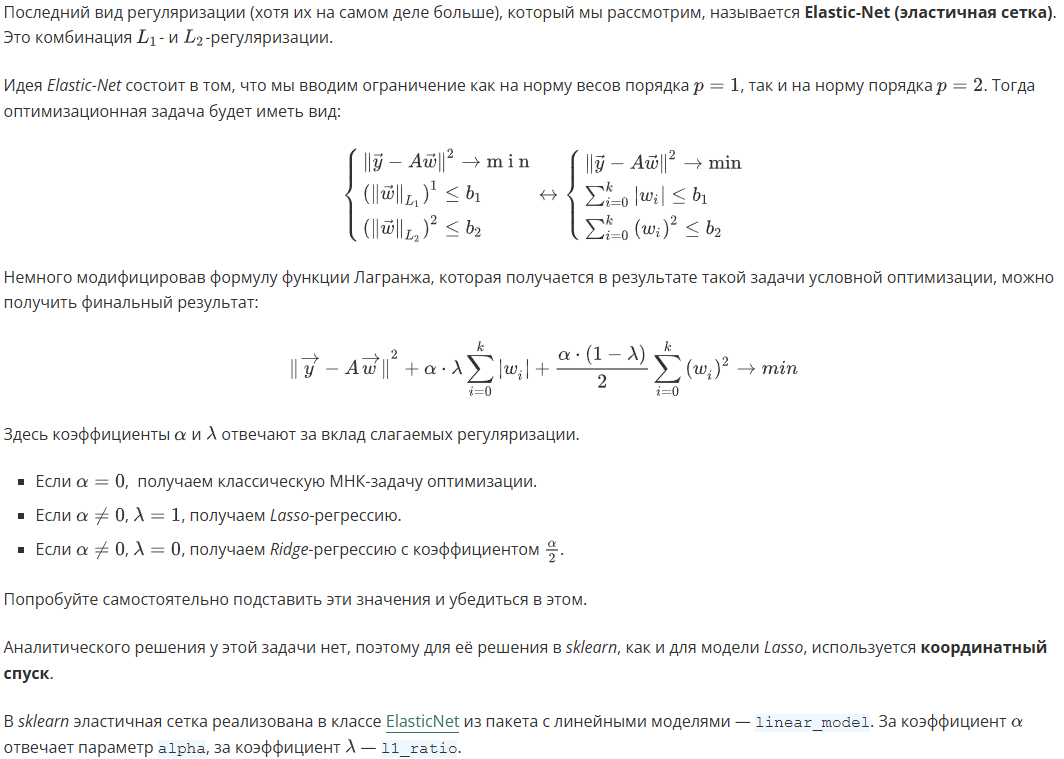
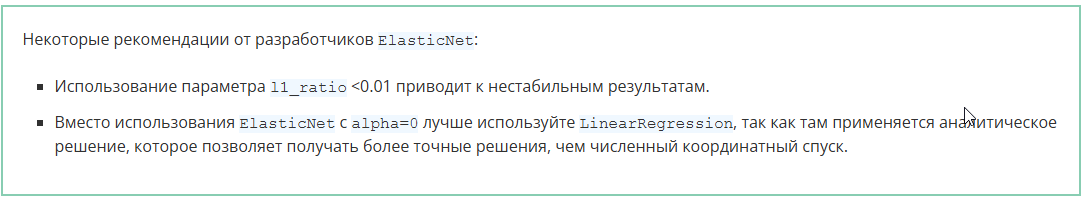

## ELASTIC-NET - python

In [42]:
from sklearn.linear_model import ElasticNet

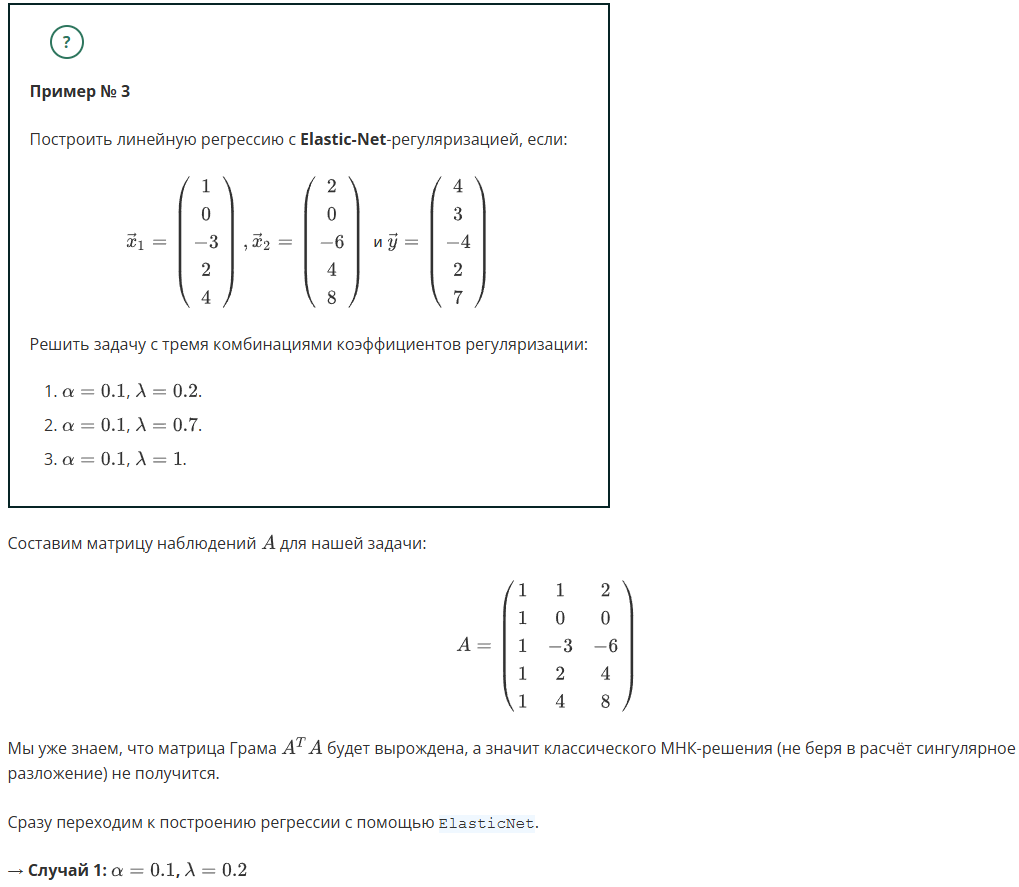

In [43]:
# матрица наблюдений (включая столбец единиц)
A = np.array([
    [1, 1, 1, 1, 1],
    [1, 0, -3, 2, 4],
    [2, 0, -6, 4, 8]
]).T
# вектор целевого признака
y = np.array([4, 3, -4, 2, 7])
# получаем оценку коэффициентов регрессии 
elasticnet = ElasticNet(alpha=0.1, l1_ratio=0.2, fit_intercept=False)
elasticnet.fit(A, y)
print(elasticnet.coef_)
## [1.13492457 0.19525842 0.6237965 ]

[1.13492457 0.19525842 0.6237965 ]


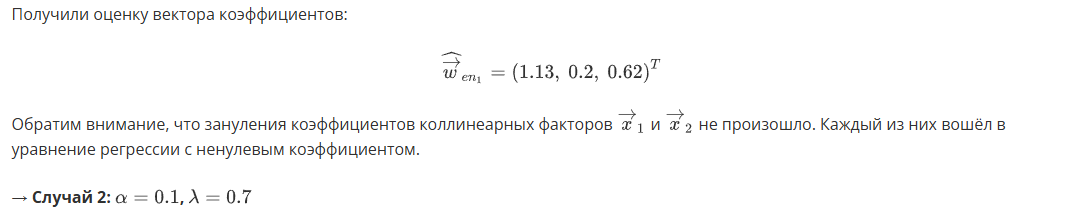

In [44]:
# получаем оценку коэффициентов регрессии
elasticnet = ElasticNet(alpha=0.1, l1_ratio=0.7, fit_intercept=False)
elasticnet.fit(A, y)
print(elasticnet.coef_)
## [1.14379753 0.         0.71993025]

[1.14379753 0.         0.71993025]


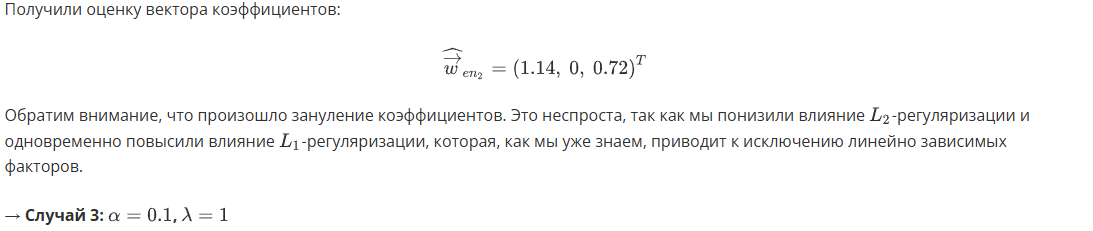

In [45]:
# получаем оценку коэффициентов регрессии
elasticnet = ElasticNet(alpha=0.1, l1_ratio=1, fit_intercept=False)
elasticnet.fit(A, y)
print(elasticnet.coef_)
## [1.14925373 0.         0.71921642]

[1.14925373 0.         0.71921642]


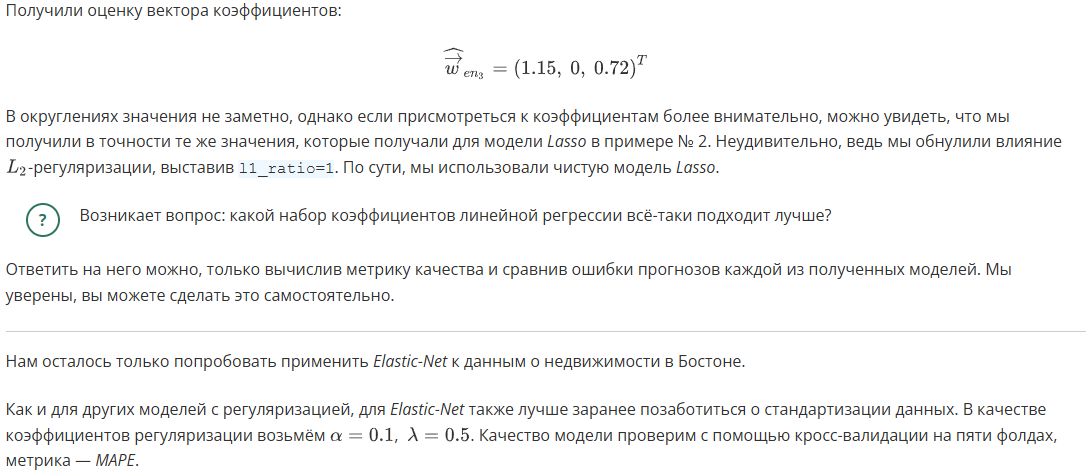

In [46]:
# выделяем интересующие нас факторы
X = boston_data[['LSTAT', 'PTRATIO', 'RM','CRIM']]
y = boston_data[['PRICE']]
# инициализируем стандартизатор StandardScaler
scaler = StandardScaler()
# подгоняем параметры стандартизатора (вычисляем среднее и СКО)
X = scaler.fit_transform(X)
# добавляем полиномиальные признаки
poly = PolynomialFeatures(degree=3, include_bias=False)
X = poly.fit_transform(X)
# создаём модель линейной регрессии c L1- и L2-регуляризациями
lasso = ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000)
# оцениваем качество модели на кросс-валидации
cv_results = cross_validate(lasso, X, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_score'].mean() * 100)) 
## MAPE на тренировочных фолдах: 12.65 %
## MAPE на валидационных фолдах: 15.70 %

MAPE на тренировочных фолдах: 12.65 %
MAPE на валидационных фолдах: 15.70 %


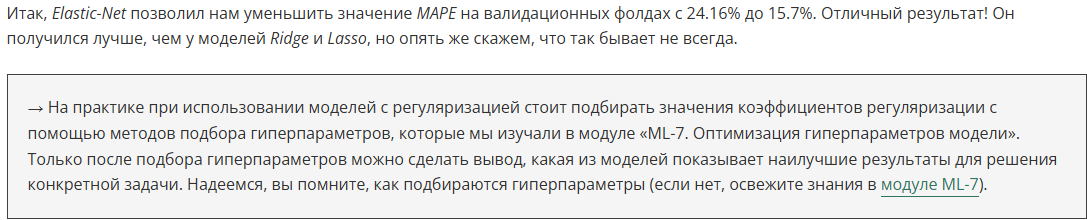

## *ГЕОМЕТРИЧЕСКАЯ ИНТЕРПРЕТАЦИЯ РЕГУЛЯРИЗАЦИИ

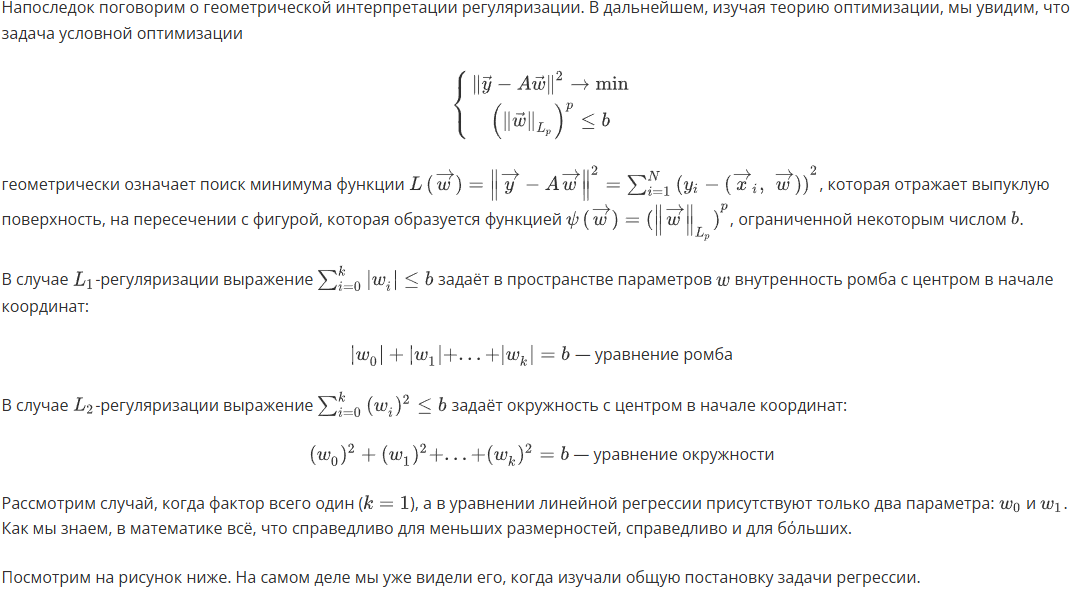
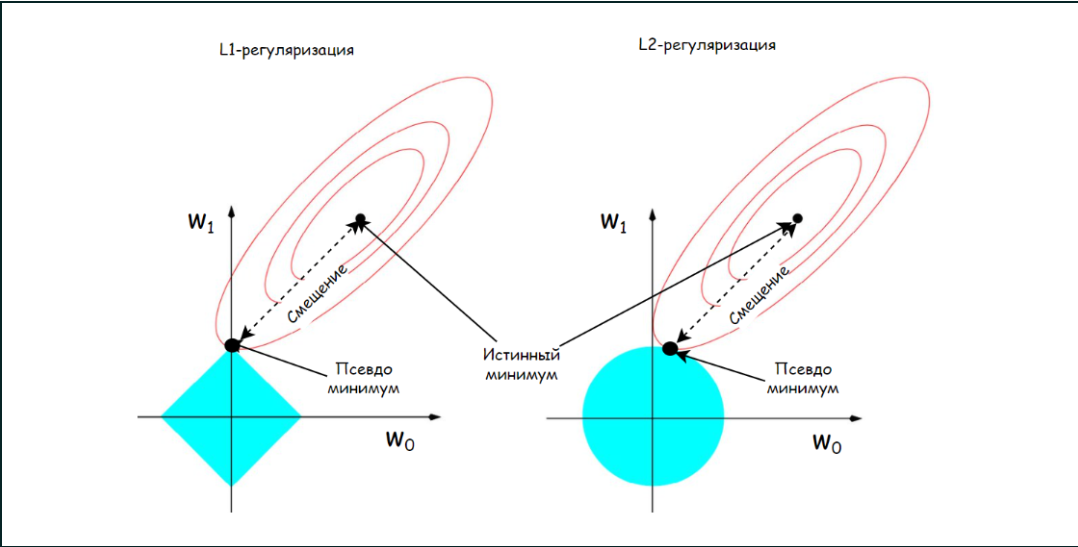
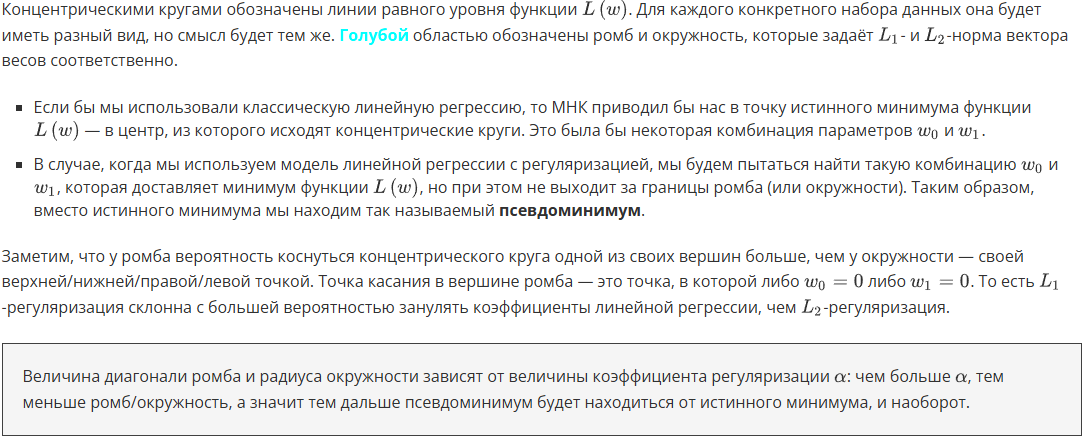